# Plate Counts Analysis — Fixed & Robust

✅ Saved daily_summary_with_plate_counts.csv and daily_checks_with_plate_counts.csv


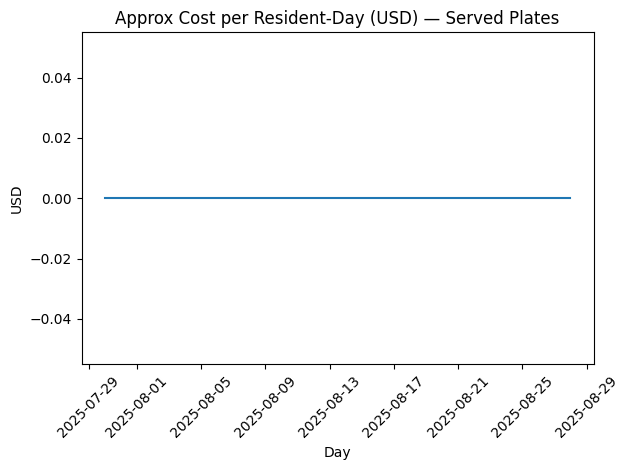

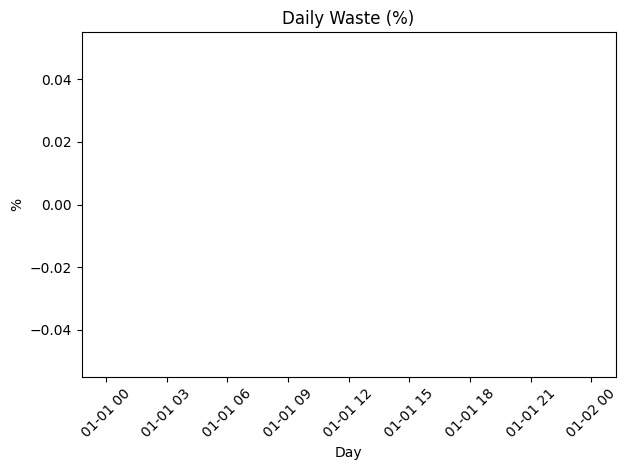

In [1]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt

BASE = "/Projects/memory_care_meals"

residents = pd.read_csv(f"{BASE}/residents.csv")
recipes   = pd.read_csv(f"{BASE}/recipes.csv")
menu      = pd.read_csv(f"{BASE}/menu_calendar.csv")
standards = pd.read_csv(f"{BASE}/nutrition_standards_daily.csv")
try:
    plates = pd.read_csv(f"{BASE}/plate_counts.csv")
except FileNotFoundError:
    plates = pd.DataFrame(columns=["date","meal_type","recipe_id","prepared","served","leftover"])

for df in (recipes, menu, plates, standards):
    df.columns = [c.strip().lower() for c in df.columns]

for df in (menu, plates):
    if "recipe_id" in df.columns:
        df["recipe_id"] = pd.to_numeric(df["recipe_id"], errors="coerce")
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")

menu_detail = menu.merge(recipes, on="recipe_id", how="left")
if "meal_type_x" in menu_detail.columns and "meal_type_y" in menu_detail.columns:
    menu_detail["meal_type"] = menu_detail["meal_type_x"].combine_first(menu_detail["meal_type_y"])
    menu_detail = menu_detail.drop(columns=["meal_type_x","meal_type_y"])

if "meal_type" not in plates.columns or plates["meal_type"].isna().any():
    plates = plates.merge(menu[["date","recipe_id","meal_type"]].drop_duplicates(), on=["date","recipe_id"], how="left")

merge_keys = ["date","recipe_id"]
plate_cols = ["date","recipe_id","prepared","served","leftover"]
if "meal_type" in plates.columns:
    plate_cols.insert(1, "meal_type")

detail = menu_detail.merge(plates[plate_cols], on=merge_keys, how="left", validate="m:1")

detail["cost_served"] = detail["estimated_cost_per_serving_usd"] * detail["served"]
detail["date"] = pd.to_datetime(detail["date"], errors="coerce")
daily = (
    detail.assign(day=detail["date"].dt.date)
    .groupby("day", as_index=False)
    .agg(
        calories_kcal=("calories_kcal","sum"),
        protein_g=("protein_g","sum"),
        carbs_g=("carbs_g","sum"),
        fat_g=("fat_g","sum"),
        sodium_mg=("sodium_mg","sum"),
        fiber_g=("fiber_g","sum"),
        prepared=("prepared","sum"),
        served=("served","sum"),
        leftover=("leftover","sum"),
        cost_served=("cost_served","sum"),
    )
)

for col in ["prepared","served","leftover","cost_served"]:
    daily[col] = pd.to_numeric(daily[col], errors="coerce").fillna(0)

daily["waste_pct"] = np.divide(
    daily["leftover"].astype(float),
    daily["prepared"].replace(0, np.nan).astype(float)
)
daily["cost_per_served_plate_usd"] = np.divide(
    daily["cost_served"].astype(float),
    daily["served"].replace(0, np.nan).astype(float)
)
daily["approx_cost_per_resident_day_usd"] = daily["cost_served"] / max(len(residents), 1)

daily.to_csv(f"{BASE}/daily_summary_with_plate_counts.csv", index=False)

def within_range(val, metric, std):
    row = std[std["metric"]==metric].iloc[0]
    return (val >= row["min"]) and (val <= row["max"])

checks = pd.DataFrame({
    "day": daily["day"],
    "calories_ok": daily["calories_kcal"].apply(lambda x: within_range(x, "calories_kcal", standards)),
    "protein_ok":  daily["protein_g"].apply(lambda x: within_range(x, "protein_g", standards)),
    "carbs_ok":    daily["carbs_g"].apply(lambda x: within_range(x, "carbs_g", standards)),
    "fat_ok":      daily["fat_g"].apply(lambda x: within_range(x, "fat_g", standards)),
    "sodium_ok":   daily["sodium_mg"].apply(lambda x: within_range(x, "sodium_mg", standards)),
    "fiber_ok":    daily["fiber_g"].apply(lambda x: within_range(x, "fiber_g", standards)),
})
checks.to_csv(f"{BASE}/daily_checks_with_plate_counts.csv", index=False)
print("✅ Saved daily_summary_with_plate_counts.csv and daily_checks_with_plate_counts.csv")

daily_sorted = daily.sort_values("day")
plt.figure(); plt.plot(daily_sorted["day"], daily_sorted["approx_cost_per_resident_day_usd"]); plt.title("Approx Cost per Resident-Day (USD) — Served Plates"); plt.xlabel("Day"); plt.ylabel("USD"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(daily_sorted["day"], daily_sorted["waste_pct"]*100.0); plt.title("Daily Waste (%)"); plt.xlabel("Day"); plt.ylabel("%"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
